# Cleaning text and export training data (All The News)

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import re
import json
import numpy as np
import glob
import matplotlib.pyplot as plt

Helper functions

In [2]:
with open('contractions.json', 'r') as contractions_file:
    contractions_dict = json.load(contractions_file)

# expand contractions
def expand_contractions(content):
    for original, replacement in contractions_dict.items():
        content = content.replace(original, replacement)
    return content

# text cleaning applied to articles from any source
def clean_text(text):
    # general rules
    text = text.replace('U.S.', 'United States')
    text = text.replace('U.S', 'United States')
    text = text.replace('Associated Press', '')
    text = text.replace('U.N.', 'United Nations')
    
    # lowercase
    text = text.lower()
    
    # expand contractions
    text = expand_contractions(text)
    
    return ' '.join(tokenizer.tokenize(text))

## Fox News (N = 1808)

Loading dataset of articles selected from webhose and google news scrape

In [3]:
dataset = pd.read_csv("../data_raw/all_the_news/foxnews.csv", index_col=0)
politics = dataset[dataset['section']=='politics']

cleaned_data_left_right = []
fox_lengths = []
count = 0

for index, row in politics.iterrows():
    text = row['content'].replace('Sign in to comment', '')\
        .replace(']', '')\
        .replace('\xa0', '')\
        .replace('The Associated Press contributed to this report', '')\
        .replace('Fox', '')\
        .replace("’", "\'")
    fox_sub1 = re.compile(re.escape('foxnews'), re.IGNORECASE)
    text = fox_sub1.sub('', text)
    fox_sub2 = re.compile(re.escape('fox news'), re.IGNORECASE)
    text = fox_sub2.sub('', text)
    try:
        text = re.search(r'(\A.*)Twitter+', text, re.DOTALL|re.IGNORECASE).group(1)
        try:
            text = re.search(r'Click for(\A.*)\.+', text, re.IGNORECASE).group(1)
        except:
            try:
                text = re.search(r'(\A.*)THE RULEBOOK+', text, re.IGNORECASE).group(1)
            except:
                text = re.sub(r"\n(.*?) contributed to this report.", "", text)
    except:
        try:
            text = re.search(r'Click for(\A.*)\.+', text, re.IGNORECASE).group(1)
        except:
            try:
                text = re.search(r'(\A.*)THE RULEBOOK+', text, re.IGNORECASE).group(1)
            except:
                text = re.sub(r"\n(.*?) contributed to this report.", "", text)

    text_no_punc = tokenizer.tokenize(text)
    if 'Buzz Cut' not in text and 'WITH YOUR SECOND CUP OF COFFEE' not in text and '___' not in text and 'Power Play' not in text and '++++++++' not in text:
        if len(text_no_punc) < 2000 and len(text_no_punc) > 200:
            fox_lengths.append(len(text_no_punc))
            final_text = clean_text(text)
            cleaned_data_left_right.append({
                'date': row['date'],
                'text': final_text,
                'label': 1
            })

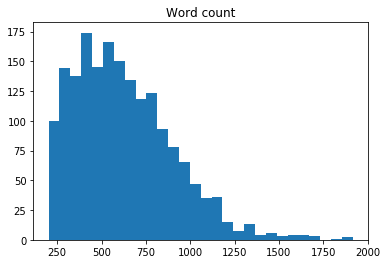

1808


In [4]:
plt.hist(fox_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Word count")
plt.show()
print(len(fox_lengths))

In [5]:
fox_df = pd.DataFrame(cleaned_data_left_right)
fox_df.to_csv('../data_processed/atn_fox_with_bias_label.csv', index=False)

## New York Post (N = 2006)

In [6]:
cleaned_data_left_right = []
nyp_lengths = []
dataset = pd.read_csv("../data_raw/all_the_news/new_york_post.csv", index_col=0)
dataset = dataset.dropna(subset = ['content']) 
political_words = ['trump', 'obama', 'foreign policy', 'u.n.', 'hillary', 'politic', 'democrat', 'republican', 'election', 'president trump', 'president obama', 'presidential',
                  'senate', 'congress']
non_political_words = ['nfl', 'sports', 'ncaa', 'final four', 'march madness', 'football', 'basketball', 'nhl', 'hockey' 'jewelry', 'fashion', 'mortgage', 'celebrity',
                       'album', 'world series', 'music', 'actress', 'actor', 'realty', 'real estate', 'hotel', 'condo', 'dow jones', 'stock exchange', 'apple']
for index, row in dataset.iterrows():
    text = row['content']
    flag = False
    for political_word in political_words:
        if political_word in text.lower():
            flag = True
            for non_political_word in non_political_words:
                if non_political_word in text.lower():
                    flag = False
    if flag and 'fox' not in text.lower() and '@' not in text and len(tokenizer.tokenize(text)) > 200:
        text = text.replace('AP', '').replace('Reuters', '')
        final_text = clean_text(text)
        nyp_lengths.append(len(tokenizer.tokenize(text)))
        cleaned_data_left_right.append({
            'date': row['date'],
            'text': final_text,
            'label': 1
        })

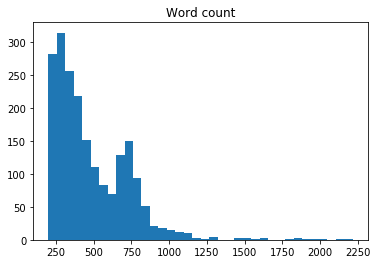

2006


In [7]:
plt.hist(nyp_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Word count")
plt.show()
print(len(nyp_lengths))

In [8]:
nypost_df = pd.DataFrame(cleaned_data_left_right)
nypost_df.to_csv('../data_processed/atn_nypost_with_bias_label.csv', index=False)

## National Review (N = 2595)

In [9]:
count = 0
cleaned_data_left_right = []
cleaned_data_bias_level = []
nr_lengths = []

political_words = ['trump', 'obama', 'foreign policy', 'u.n.', 'hillary', 'politic', 'democrat', 'republican', 'election', 'president trump', 'president obama', 'presidential',
                  'senate', 'congress']
non_political_words = ['nfl', 'sports', 'ncaa', 'final four', 'march madness', 'football', 'basketball', 'nhl', 'hockey' 'jewelry', 'fashion', 'mortgage', 'celebrity',
                       'album', 'world series', 'music', 'actress', 'actor', 'realty', 'real estate', 'hotel', 'condo', 'dow jones', 'stock exchange', 'apple']

dataset = pd.read_csv("../data_raw/all_the_news/national_review.csv", index_col=0)
dataset = dataset.dropna(subset = ['content'])
for index, row in dataset.iterrows():
    text = row['content']
    author = row['author'].lower()
    flag = False
    for political_word in political_words:
        if political_word in text.lower():
            flag = True
            for non_political_word in non_political_words:
                if non_political_word in text.lower():
                    flag = False
    if flag:
        text = text.replace("\xa0", "")
        try:
            text = re.search(r'(\A.*){}+'.format(author), text, re.IGNORECASE).group(1)
        except:
            count+=1
        if '@' not in text and len(tokenizer.tokenize(text)) > 200 and len(tokenizer.tokenize(text)) < 2000:
            final_text = clean_text(text)
            nr_lengths.append(len(tokenizer.tokenize(text)))
            cleaned_data_left_right.append({
                'date': row['date'],
                'text': final_text,
                'label': 1
            })
            cleaned_data_bias_level.append({
                'date': row['date'],
                'text': final_text,
                'label': 2
            })

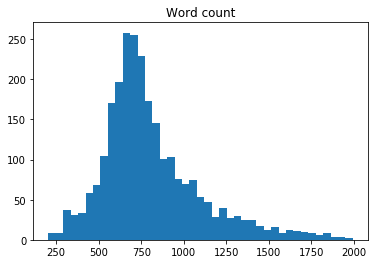

2595


In [10]:
plt.hist(nr_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Word count")
plt.show()
print(len(nr_lengths))

In [11]:
national_review_label = pd.DataFrame(cleaned_data_left_right)
national_review_level = pd.DataFrame(cleaned_data_bias_level)
national_review_label.to_csv('../data_processed/atn_national_review_with_bias_label.csv', index=False)
national_review_level.to_csv('../data_processed/atn_national_review_with_bias_level.csv', index=False)

## New York Times (N = 1790)

In [12]:
count = 0
cleaned_data_left_right = []
cleaned_data_bias_level = []
nyt_lengths = []

political_words = ['trump', 'obama', 'foreign policy', 'u.n.', 'hillary', 'politic', 'democrat', 'republican', 'election', 'president trump', 'president obama', 'presidential',
                  'senate', 'congress']
non_political_words = ['nfl', 'sports', 'ncaa', 'final four', 'march madness', 'football', 'basketball', 'nhl', 'hockey' 'jewelry', 'fashion', 'mortgage', 'celebrity',
                       'album', 'world series', 'music', 'actress', 'actor', 'realty', 'real estate', 'hotel', 'condo', 'dow jones', 'stock exchange', 'apple']

dataset = pd.read_csv("../data_raw/all_the_news/new_york_times_2017_1.csv", index_col=0)
dataset = dataset.dropna(subset = ['content'])

for index, row in dataset.iterrows():
    text = row['content']
    author = row['author']
    flag = False
    for political_word in political_words:
        if political_word in text.lower():
            flag = True
            for non_political_word in non_political_words:
                if non_political_word in text.lower():
                    flag = False
    if flag:
        text = text.replace("’", "\'")
        try:
            text = re.search(r'(\A.*){}+'.format(author), text, re.IGNORECASE).group(1)
        except:
            count+=1
        if '@' not in text and len(tokenizer.tokenize(text)) > 100 and len(tokenizer.tokenize(text)) < 2000:
            nyt_lengths.append(len(tokenizer.tokenize(text)))
            final_text = clean_text(text)
            cleaned_data_left_right.append({
                'date': row['date'],
                'text': final_text,
                'label': 0
            })
            cleaned_data_bias_level.append({
                'date': row['date'],
                'text': final_text,
                'label': 1
            })

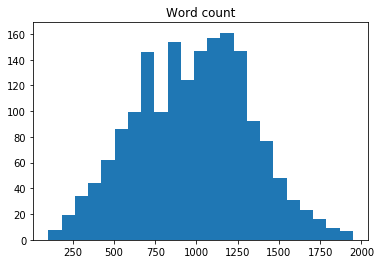

1790


In [13]:
plt.hist(nyt_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Word count")
plt.show()
print(len(nyt_lengths))

In [14]:
nyt_label = pd.DataFrame(cleaned_data_left_right)
nyt_level = pd.DataFrame(cleaned_data_bias_level)
nyt_label.to_csv('../data_processed/atn_nyt_with_bias_label.csv', index=False)
nyt_level.to_csv('../data_processed/atn_nyt_with_bias_level.csv', index=False)

## Washington Post (N = 1978)

In [15]:
dataset = pd.read_csv("../data_raw/all_the_news/washington_post.csv", index_col=0)
dataset = dataset.dropna(subset = ['content'])
politics = dataset[dataset['section']=='politics']
politics.head()

,title,author,date,content,year,month,publication,category,digital,section,url
id,,,,,,,,,,,
204045,"Roberts steers clear of controversy, praises d...",Robert Barnes,2016-12-31,The federal courts in general and the Supreme...,2016.0,12.0,Washington Post,newspaper,0,politics,https://web.archive.org/web/20170101001641/htt...
204062,Priebus faces daunting task bringing order to ...,Karen Tumulty,2017-01-01,Reince Priebus says that one of his most impo...,2017.0,1.0,Washington Post,newspaper,0,politics,https://web.archive.org/web/20170102001713/htt...
204085,"Claiming mandate, GOP Congress lays plans to p...",David Weigel,2017-01-01,"For six years, since they took back the House...",2017.0,1.0,Washington Post,newspaper,0,politics,https://web.archive.org/web/20170103000951/htt...
204089,Trump questions quest for cybersecurity: ‘No c...,Mike DeBonis,2017-01-01,President-elect Donald Trump has repeatedly q...,2017.0,1.0,Washington Post,newspaper,0,politics,https://web.archive.org/web/20170103000951/htt...
204138,How Julian Assange evolved from pariah to paragon,David Weigel,2017-01-04,President-elect Donald Trump tweeted some pra...,2017.0,1.0,Washington Post,newspaper,0,politics,https://web.archive.org/web/20170105013757/htt...


In [19]:
count = 0
cleaned_data_left_right = []
cleaned_data_bias_level = []
washpo_lengths = []
for index, row in politics.iterrows():
    author = row['author']
    text = row['content'].replace('The Washington Post', '').replace('{}'.format(author), '').replace("’", "\'")
    
    text_no_punc = tokenizer.tokenize(text)
    
    if len(text_no_punc) > 100 and len(text_no_punc) < 2500:
        washpo_lengths.append(len(text_no_punc))
        final_text = clean_text(text)
        cleaned_data_left_right.append({
            'date': row['date'],
            'text': final_text,
            'label': 0
        })
        cleaned_data_bias_level.append({
            'date': row['date'],
            'text': final_text,
            'label': 1
        })

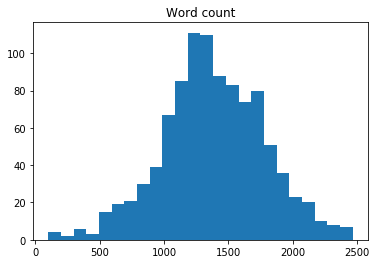

992


In [20]:
plt.hist(washpo_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Word count")
plt.show()
print(len(washpo_lengths))

In [21]:
washpost_label = pd.DataFrame(cleaned_data_left_right)
washpost_level = pd.DataFrame(cleaned_data_bias_level)
washpost_label.to_csv('../data_processed/atn_washpost_with_bias_label.csv', index=False)
washpost_level.to_csv('../data_processed/atn_washpost_with_bias_level.csv', index=False)

## The Guardian (N = 168)

In [22]:
dataset = pd.read_csv("../data_raw/all_the_news/guardian.csv", index_col=0)
dataset = dataset.dropna(subset = ['content'])
politics = dataset[dataset['section']=='politics']
politics.head()

,title,author,date,content,year,month,publication,category,digital,section,url
id,,,,,,,,,,,
145642,Tony Blair attacks Labour for providing 'zero'...,Chris Johnston,2017-04-03,Tony Blair has accused Labour of failing the B...,2017.0,4.0,Guardian,newspaper,0,politics,https://www.theguardian.com/politics/2017/apr/...
145672,Election debate: reaction and analysis after J...,Andrew Sparrow,2017-06-25,"Here is our main story about the debate., And ...",2017.0,6.0,Guardian,newspaper,0,politics,https://www.theguardian.com/politics/live/2017...
145898,Cyber-attack on UK parliament: Russia is suspe...,Ewen MacAskill,2017-06-25,The Russian government is suspected of being b...,2017.0,6.0,Guardian,newspaper,0,politics,https://www.theguardian.com/politics/2017/jun/...
145927,How Jeremy Corbyn turned a youth surge into ge...,Michael Savage,2017-06-10,"On Thursday, it will be exactly two years sinc...",2017.0,6.0,Guardian,newspaper,0,politics,https://www.theguardian.com/politics/2017/jun/...
146107,Theresa May's article 50 letter annotated,Dan Roberts,2017-03-29,This letter sets out the ... deep and special ...,2017.0,3.0,Guardian,newspaper,0,politics,https://www.theguardian.com/politics/ng-intera...


In [23]:
count = 0
cleaned_data_left_right = []
cleaned_data_bias_level = []
guardian_lengths = []
for index, row in politics.iterrows():
    author = row['author']
    text = row['content'].replace('The Guardian', '').replace('{}'.format(author), '').replace("’", "\'")
    
    text_no_punc = tokenizer.tokenize(text)
    
    if len(text_no_punc) > 100 and len(text_no_punc) < 2600:
        guardian_lengths.append(len(text_no_punc))
        final_text = clean_text(text)
        cleaned_data_left_right.append({
            'date': row['date'],
            'text': final_text,
            'label': 0
        })
        cleaned_data_bias_level.append({
            'date': row['date'],
            'text': final_text,
            'label': 1
        })

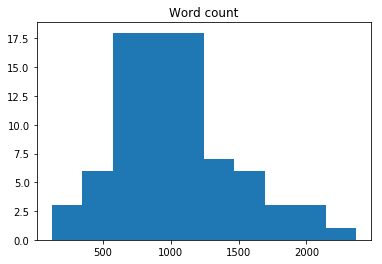

83


In [24]:
plt.hist(guardian_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Word count")
plt.show()
print(len(guardian_lengths))

## The Atlantic

In [25]:
dataset = pd.read_csv("../data_raw/all_the_news/atlantic.csv", index_col=0)
dataset = dataset.dropna(subset = ['content'])
for index, row in politics.iterrows():
    author = row['author']
    text = row['content'].replace('{}'.format(author), '').replace("’", "\'")

    text_no_punc = tokenizer.tokenize(text)
    if len(text_no_punc) > 100 and len(text_no_punc) < 4000:
        final_text = clean_text(text)
        cleaned_data_left_right.append({
            'date': row['date'],
            'text': final_text,
            'label': 0
        })
        cleaned_data_bias_level.append({
            'date': row['date'],
            'text': final_text,
            'label': 1
        })

In [26]:
label = pd.DataFrame(cleaned_data_left_right)
level = pd.DataFrame(cleaned_data_bias_level)
label.to_csv('../data_processed/atn_guardian_atlantic_with_bias_label.csv', index=False)
level.to_csv('../data_processed/atn_guardian_atlantic_with_bias_level.csv', index=False)

## CNN (N = 3272)

In [27]:
count = 0
cleaned_data_left_right = []
cleaned_data_bias_level = []
cnn_lengths = []

political_words = ['trump', 'obama', 'foreign policy', 'u.n.', 'hillary', 'politic', 'democrat', 'republican', 'election', 'president trump', 'president obama', 'presidential',
                  'senate', 'congress']
non_political_words = ['nfl', 'sports', 'ncaa', 'final four', 'march madness', 'football', 'basketball', 'nhl', 'hockey' 'jewelry', 'fashion', 'mortgage', 'celebrity',
                       'album', 'world series', 'music', 'actress', 'actor', 'realty', 'real estate', 'hotel', 'condo', 'dow jones', 'stock exchange', 'apple']

dataset = pd.read_csv("../data_raw/all_the_news/cnn.csv", index_col=0)
dataset = dataset.dropna(subset = ['content'])
dataset = dataset[dataset['date'] > '2016']

In [28]:
for index, row in dataset.iterrows():
    text = row['content']
    author = row['author']
    flag = False
    for political_word in political_words:
        if political_word in text.lower():
            flag = True
            for non_political_word in non_political_words:
                if non_political_word in text.lower():
                    flag = False
    if flag:
        text = text.replace("’", "\'").replace('CNN', '')
        if len(tokenizer.tokenize(text)) > 200 and len(tokenizer.tokenize(text)) < 2000:
            cnn_lengths.append(len(tokenizer.tokenize(text)))
            final_text = clean_text(text)
            cleaned_data_left_right.append({
                'date': row['date'],
                'text': final_text,
                'label': 0
            })
            cleaned_data_bias_level.append({
                'date': row['date'],
                'text': final_text,
                'label': 2
            })

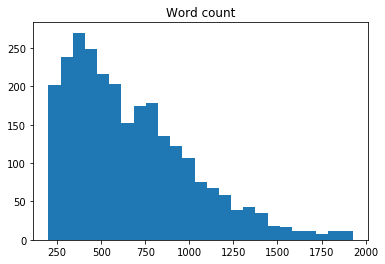

2654


In [29]:
plt.hist(cnn_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Word count")
plt.show()
print(len(cnn_lengths))

In [30]:
cnn_label = pd.DataFrame(cleaned_data_left_right)
cnn_level = pd.DataFrame(cleaned_data_bias_level)
cnn_label.to_csv('../data_processed/atn_cnn_with_bias_label.csv', index=False)
cnn_level.to_csv('../data_processed/atn_cnn_with_bias_level.csv', index=False)

## Concatenate files for Liberal vs. Conservative bias

In [31]:
files = glob.glob("../data_processed/atn_*_label.csv")
dataframe_list = []
for f in files:
    this_file = pd.read_csv(f)
    dataframe_list.append(this_file)
atn_all_df = pd.concat(dataframe_list, ignore_index=True)
atn_all_df.shape

(25012, 3)

In [32]:
atn_all_df.to_csv('../data_processed/atn_with_bias_label.csv', index=False)
atn_all_df = atn_all_df[['text', 'label']]
atn_all_df.columns = ['content', 'label']

In [33]:
recent_news_df = pd.read_csv('../data_processed/dataset_with_bias_label.csv')
recent_news_df = recent_news_df[['content', 'label']]
recent_news_df.shape

(5331, 2)

In [34]:
recent_news_df.head()

,content,label
0,hillary clinton speaks at the time 100 summit ...,0
1,president donald trump hits a new high on his ...,0
2,the broad outlines of how the bidens roles int...,0
3,nellie ohr the wife of justice department offi...,1
4,federal immigration officers working on the un...,1


In [35]:
all_bias_label_df = pd.concat([atn_all_df, recent_news_df])

In [36]:
all_bias_label_df.head()

,content,label
0,republican presidential candidate ben carson s...,1
1,a nasty battle has broken out in the republica...,1
2,donald trump launched new attacks against bill...,1
3,the plunge in oil prices has given a needed br...,1
4,president obama said on friday he will meet wi...,1


In [37]:
all_bias_label_df['label'].value_counts()

1    15226
0    15117
Name: label, dtype: int64

In [38]:
atn_all_df.to_csv('../data_processed/ALL_NEWS_bias_label.csv', index=False)

## Concatenate files for Liberal vs. Conservative bias